# Human-AI Image Detection Model Training

This notebook implements the training pipeline for detecting AI-generated vs human-created images.

In [53]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import mlflow
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer
import torch.utils.data.dataset
import random
import torch.utils
import torch.utils.data
from src.utils.save_model import save_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration

In [54]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
# print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration


## Data Loading and Preprocessing

In [55]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


## Visualize Sample Images

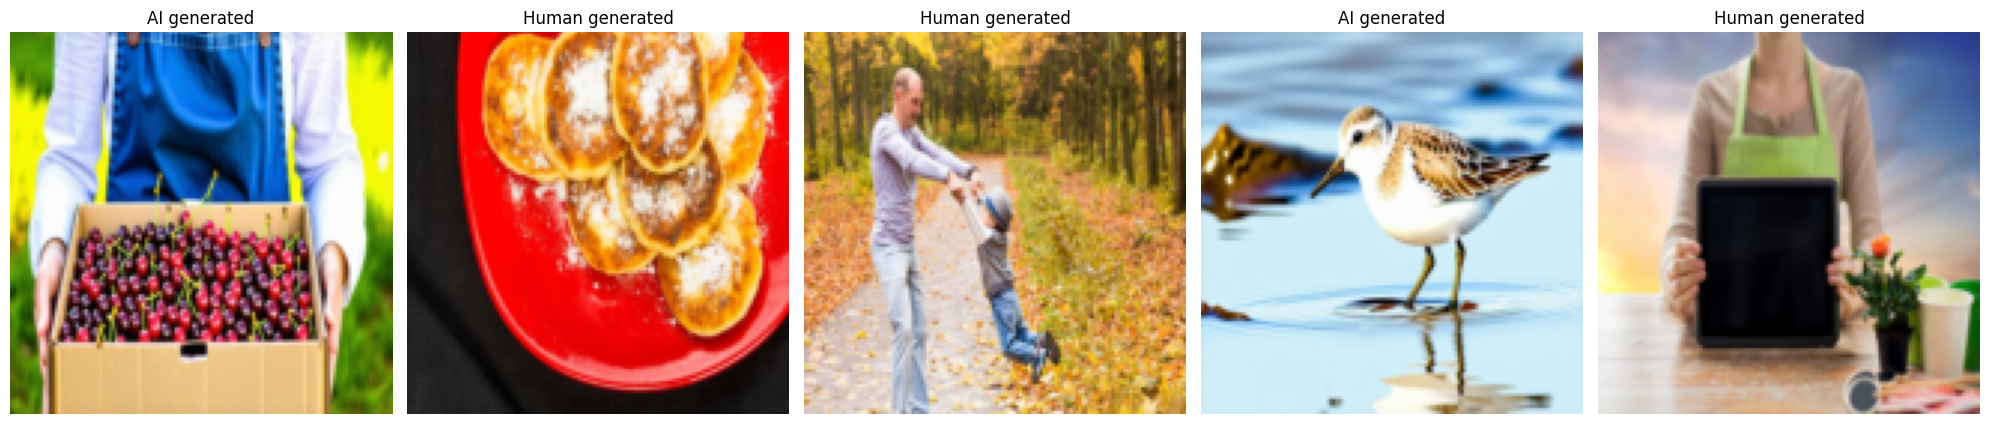

In [56]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

## Model Training and Hyperparameter Tuning

**NOTE**: Uncommet the below code to test your model working on a smaller subset

In [57]:
# trainset_size = len(trainset)
# indices = random.sample(range(trainset_size), 10)
# trainset = torch.utils.data.dataset.Subset(trainset, indices)

In [58]:
%load_ext autoreload
%autoreload 2

model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score, final_model = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
save : : str: cnwkcl:_model(best_params, best_score, final_model, 'deep_cnn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Skipping hyperparameter tuning and using default parameters.
Training deep_cnn with default parameters
Performing KFold Cross Validation with 4 folds
Epoch 1


Training: 100%|██████████| 1312/1312 [07:34<00:00,  2.89it/s, loss=0.344, acc=50]  


Epoch 2


Training: 100%|██████████| 1312/1312 [08:30<00:00,  2.57it/s, loss=0.246, acc=50.2]


Epoch 3


Training: 100%|██████████| 1312/1312 [08:24<00:00,  2.60it/s, loss=0.202, acc=50.9]


Accuracy obtained on Fold 1: 16.234991423670667
Epoch 1


Training: 100%|██████████| 1312/1312 [08:40<00:00,  2.52it/s, loss=0.148, acc=52.6]


Epoch 2


Training: 100%|██████████| 1312/1312 [08:42<00:00,  2.51it/s, loss=0.112, acc=55.9]


Epoch 3


Training: 100%|██████████| 1312/1312 [08:41<00:00,  2.52it/s, loss=0.0945, acc=57.9]


Accuracy obtained on Fold 2: 16.10835537131013
Epoch 1


Training: 100%|██████████| 1312/1312 [08:33<00:00,  2.56it/s, loss=0.101, acc=59.6] 


Epoch 2


Training: 100%|██████████| 1312/1312 [08:32<00:00,  2.56it/s, loss=0.0817, acc=60.4]


Epoch 3


Training: 100%|██████████| 1312/1312 [08:39<00:00,  2.53it/s, loss=0.0777, acc=61.8]


Accuracy obtained on Fold 3: 15.86770066471303
Epoch 1


Training: 100%|██████████| 1312/1312 [09:03<00:00,  2.41it/s, loss=0.0846, acc=63.5]


Epoch 2


Training: 100%|██████████| 1312/1312 [09:00<00:00,  2.43it/s, loss=0.07, acc=62.8]  


Epoch 3


Training: 100%|██████████| 1312/1312 [09:00<00:00,  2.43it/s, loss=0.0699, acc=63.3]


Accuracy obtained on Fold 4: 16.066185404903152
Mean score obtained from KFold: 16.069308216149246
Best parameters: {'in_channels_list': [3, 32, 64, 128], 'out_channels_list': [32, 64, 128, 256], 'kernel_size_list': [3, 3, 3, 3], 'dropout_rate': 0.7}
Best score: 16.069308216149246
Model saved to trained_models/deep_cnn.pt


## Training Visualization

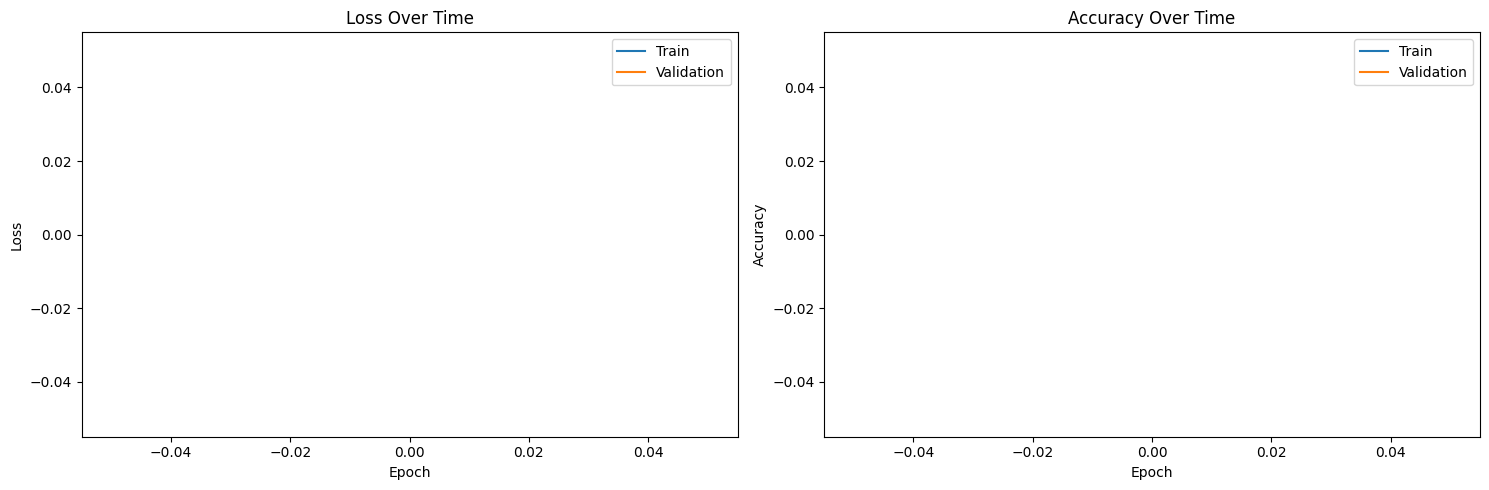

In [59]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)